In [11]:
import os
import sys
import shutil
from sklearn.model_selection import train_test_split
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm


sys.path.append(os.path.dirname(os.getcwd()))
from src.utils.const import *
from src.utils.utils import *
from src.model.dataset import MaskRCNNDataset

# Split the Multiorg dataset

First get all the paths to images and annotations

In [ ]:
train_dataset_path = "/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/train"
def get_images_paths_multiorg(dataset_path):
    image_paths = []
    ext = ['jpg', 'jpeg', 'png', 'tif', 'tiff', 'bmp']
    for root, dirs, files in os.walk(dataset_path):
        for filename in files:
            if filename.split('.')[-1] in ext and filename[0]!='.':
                image_paths.append(os.path.join(root, filename))
    return image_paths

def get_annotations_paths_multiorg(dataset_path, images_paths):
    annotations_paths = []
    for img_path in images_paths:
        img_dir = os.path.dirname(img_path)
        found = False
        for path in os.listdir(img_dir):
            if path.endswith('.json'):
                found = True
                annotations_paths.append(os.path.join(img_dir, path))
                break
        if not found:
            raise FileNotFoundError(f"No annotation found for {img_path}")
    return annotations_paths

images_paths = get_images_paths_multiorg(train_dataset_path)
annotations_paths = get_annotations_paths_multiorg(train_dataset_path, images_paths)

Split the paths between the ones annotated by Annotator A and B.

In [3]:
images_paths_A = []
images_paths_B = []
annotations_paths_A = []
annotations_paths_B = []

for i, a in zip(images_paths, annotations_paths):
    if 'Annotator_A' in os.path.basename(a):
        images_paths_A.append(i)
        annotations_paths_A.append(a)
    elif 'Annotator_B' in os.path.basename(a):
        images_paths_B.append(i)
        annotations_paths_B.append(a)
    else:
        raise ValueError(f"Annotation file {a} does not contain A_ or B_")

do an 80 20 train val split of the images by preserving te distributino of #det

/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_87381/1698267459.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([nr_detections_A, nr_detections_train_A, nr_detections_val_A], labels=['All A', 'Train A', 'Val A'])
/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_87381/1698267459.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([nr_detections_B, nr_detections_train_B, nr_detections_val_B], labels=['All B', 'Train B', 'Val B'])


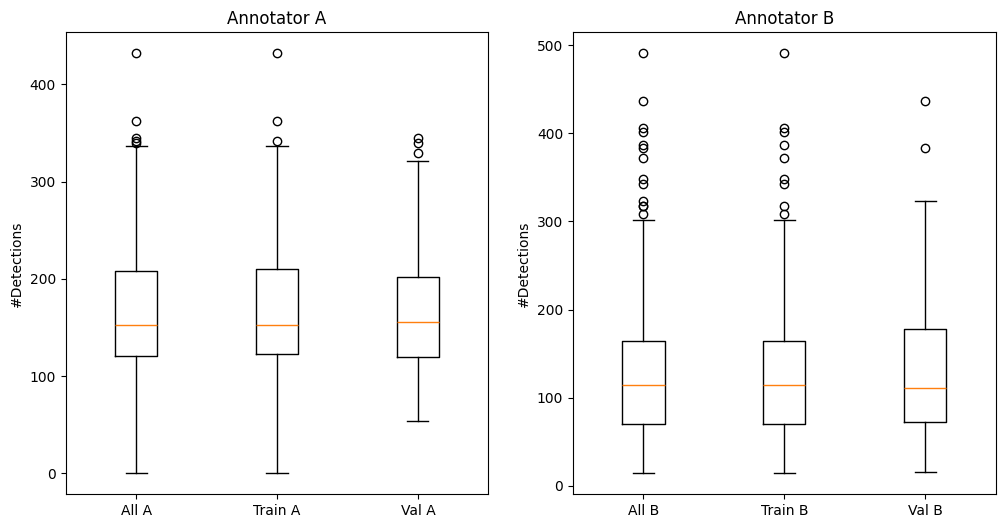

Number of images per set:
Train A: 156
Val A: 40
Train B: 128
Val B: 32


In [4]:
def get_nr_det(annotations_paths: str):
    nr_det = []
    for annotations_path in annotations_paths:
        with open(annotations_path, 'r') as f:
            ann = json.load(f)
        nr_det.append(len(ann.keys()))
    return nr_det

def bin(data: list, n_bins: int):
    """
    Bin the data into n_bins bins of similar size
    :param data: data to be binned
    :param n_bins: number of bins
    :return: binned data
    """
    data = np.array(data)
    # sort the data
    sorted_indices = data.argsort()
    bins = np.linspace(0, len(data), n_bins + 1)
    binned_data = np.digitize(sorted_indices, bins) - 1
    return binned_data


nr_detections_A = get_nr_det(annotations_paths_A)
nr_detections_B = get_nr_det(annotations_paths_B)

images_train_A, images_val_A, annotations_train_A, annotations_val_A = train_test_split(
    images_paths_A, annotations_paths_A, test_size=0.2, random_state=42, stratify=bin(nr_detections_A, 4),
)
images_train_B, images_val_B, annotations_train_B, annotations_val_B = train_test_split(
    images_paths_B, annotations_paths_B, test_size=0.2, random_state=24, stratify=bin(nr_detections_B, 4)
)
nr_detections_train_A = get_nr_det(annotations_train_A)
nr_detections_train_B = get_nr_det(annotations_train_B)
nr_detections_val_A = get_nr_det(annotations_val_A)
nr_detections_val_B = get_nr_det(annotations_val_B)

# plot the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].boxplot([nr_detections_A, nr_detections_train_A, nr_detections_val_A], labels=['All A', 'Train A', 'Val A'])
axes[0].set_title('Annotator A')
axes[0].set_ylabel('#Detections')
axes[1].boxplot([nr_detections_B, nr_detections_train_B, nr_detections_val_B], labels=['All B', 'Train B', 'Val B'])
axes[1].set_title('Annotator B')
axes[1].set_ylabel('#Detections')
plt.show()
print(f"Number of images per set:")
print(f"Train A: {len(images_train_A)}")
print(f"Val A: {len(images_val_A)}")
print(f"Train B: {len(images_train_B)}")
print(f"Val B: {len(images_val_B)}")

# Create patches and assign to each patch the detections athat are entirely contained

The paches have a 50% overlap (followed the procedure of the original paper)

In [5]:
from skimage import io, img_as_ubyte, exposure

def squeeze_img(img):
    """ Squeeze image - all dims that have size one will be removed """
    return np.squeeze(img)

def apply_normalization(img):
    """ Normalize image"""
    # squeeze and change dtype
    img = squeeze_img(img)
    img = img.astype(np.float64)
    # adapt img to range 0-255
    img_min = np.min(img) # 31.3125 png 0
    img_max = np.max(img) # 2899.25 png 178
    img_norm = (255 * (img - img_min) / (img_max - img_min)).astype(np.uint8)
    return img_norm

In [6]:

def create_patches(img_path, ann_path, size=2048, overlap: float = 0.25):
    img = io.imread(img_path)
    img = apply_normalization(img)
    img_height, img_width = img.shape

    ann = json.load(open(ann_path, 'r'))
    ann_df = pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2'])
    for _, box in ann.items():
        x1 = box[0][1]
        x2 = box[2][1]
        y1 = box[0][0]
        y2 = box[1][0]
        ann_df.loc[len(ann_df)] = [x1, y1, x2, y2]
    
    patches = []
    annotations_patches = []

    for x in list(range(0, img_width-size, int(size*(1-overlap)))) + [img_width-size]:
        for y in list(range(0, img_height-size, int(size*(1-overlap)))) + [img_height-size]:
            # print(f"Creating patch at x: {x} to {x + size}, y: {y} to {y + size}")
            patch = img[y:y + size, x:x + size]
            patches.append(patch)

            # Create corresponding annotation patch
            ann_patch = ann_df[(ann_df['x1'] >= x) & (ann_df['x2'] <= x + size) & (ann_df['y1'] >= y) & (ann_df['y2'] <= y + size)]
            ann_patch = ann_patch.copy()
            ann_patch['x1'] = ann_patch['x1'] - x
            ann_patch['y1'] = ann_patch['y1'] - y
            ann_patch['x2'] = ann_patch['x2'] - x
            ann_patch['y2'] = ann_patch['y2'] - y
            annotations_patches.append(ann_patch)


    return patches, annotations_patches

def generate_dataset(images_paths, annotations_paths, dataset_path, output_path):
    if os.path.exists(output_path):
        shutil.rmtree(output_path, ignore_errors=True)
    os.makedirs(output_path, exist_ok=True)
    images_path = os.path.join(output_path, IMAGES_SUBFOLDER)
    annotations_path = os.path.join(output_path, ANNOTATIONS_SUBFOLDER)
    os.makedirs(images_path, exist_ok=True)
    os.makedirs(annotations_path, exist_ok=True)

    for img_path, ann_path in tqdm(zip(images_paths, annotations_paths)):
        patches, annotations_patches = create_patches(img_path, ann_path)
        # save them
        rel_dir = os.path.relpath(os.path.dirname(img_path), dataset_path)
        name = os.path.basename(img_path).split('.')[0]
        patch_dir = os.path.join(output_path, IMAGES_SUBFOLDER, rel_dir)
        ann_dir = os.path.join(output_path, ANNOTATIONS_SUBFOLDER, rel_dir)
        os.makedirs(patch_dir, exist_ok=True)
        os.makedirs(ann_dir, exist_ok=True)
        for i, (patch, ann) in enumerate(zip(patches, annotations_patches)):
            patch_path = os.path.join(patch_dir, f"{name}_patch_{i}.tiff")
            ann_path = os.path.join(ann_dir, f"{name}_patch_{i}{BBOXES_SUFF}.csv")
            # save
            io.imsave(patch_path, patch)
            ann.to_csv(ann_path)


generate_dataset(images_train_A, annotations_train_A, train_dataset_path, "/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/train_A")
generate_dataset(images_val_A, annotations_val_A, train_dataset_path, "/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/val_A")
generate_dataset(images_train_B, annotations_train_B, train_dataset_path, "/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/train_B")
generate_dataset(images_val_B, annotations_val_B, train_dataset_path, "/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/val_B")


156it [02:04,  1.25it/s]
40it [00:29,  1.35it/s]
128it [01:33,  1.36it/s]
32it [00:23,  1.35it/s]


# Merge the images

We create a third dataset that has images from bot annotators

In [13]:
def path_new_dataset(data_path, old_dataset_path, new_dataset_path):
    return os.path.join(new_dataset_path, os.path.relpath(data_path, old_dataset_path))

def copy_dataset(images_paths, annotations_paths, old_dataset_path, new_dataset_path):
    for img_path, ann_path in zip(images_paths, annotations_paths):
        new_img_path = path_new_dataset(img_path, old_dataset_path, new_dataset_path)
        new_ann_path = path_new_dataset(ann_path, old_dataset_path, new_dataset_path)
        os.makedirs(os.path.dirname(new_img_path), exist_ok=True)
        os.makedirs(os.path.dirname(new_ann_path), exist_ok=True)
        shutil.copy(img_path, new_img_path)
        shutil.copy(ann_path, new_ann_path)

def merge_dataset(dataset_1_path, dataset_2_path, new_dataset_path):
    os.makedirs(new_dataset_path, exist_ok=True)
    images_1_paths = get_images_paths(dataset_1_path)
    annotations_1_paths = get_annotations_paths(images_1_paths, dataset_1_path)
    copy_dataset(images_1_paths, annotations_1_paths, dataset_1_path, new_dataset_path)
    images_2_paths = get_images_paths(dataset_2_path)
    annotations_2_paths = get_annotations_paths(images_2_paths, dataset_2_path)
    copy_dataset(images_2_paths, annotations_2_paths, dataset_2_path, new_dataset_path)

# merge train datasets
merge_dataset(
    "/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/train_A", 
    "/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/train_B", 
    "/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/train_AB")
merge_dataset(
    "/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/val_A", 
    "/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/val_B", 
    "/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/val_AB")


In [14]:
# check that all dataset generated are complete
check_dataset("/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/train_A")
check_dataset("/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/train_B")
check_dataset("/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/train_AB")
check_dataset("/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/val_A")
check_dataset("/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/val_B")
check_dataset("/Volumes/Extreme_SSD/Gastrointestinal_voucher/archive/val_AB")

True